- Id - um Id que representa um duplicado (Loja, Data) dentro do conjunto de teste

- Loja - um Id exclusivo para cada loja

- Vendas - o volume de negócios de um determinado dia (é isso que você está prevendo)

- Clientes - o número de clientes em um determinado dia

- Aberto - um indicador para saber se a loja estava aberta: 0 = fechada, 1 = aberta

- FeriadoEstadual - indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, fecham em feriados estaduais. Observe que todas as escolas fecham em feriados e fins de semana. a = - feriado, b = Páscoa, c = Natal, 0 = Nenhum

- SchoolHoliday - indica se a (Loja, Data) foi afetada pelo fechamento de escolas públicas

- StoreType  - diferencia entre 4 modelos de loja diferentes: a, b, c, d

- Sortimento - descreve um nível de sortimento: a = básico, b = extra, c = estendido

- CompetitionDistance - distância em metros até a loja concorrente mais próxima

- CompetitionOpenSince[Mês/Ano] - fornece o ano e o mês aproximados da abertura do concorrente mais próximo

- Promoção - indica se uma loja está realizando uma promoção naquele dia

- Promo2 - Promo2 é uma promoção contínua e consecutiva para algumas lojas: 0 = loja não está participando, 1 = loja está participando

- Promo2Since[Ano/Semana] - descreve o ano e a semana do calendário em que a loja começou a participar do Promo2

- PromoInterval - descreve os intervalos consecutivos em que a Promo2 é iniciada, indicando os meses em que a promoção é reiniciada. Por exemplo, "fev, mai, ago, nov" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para aquela loja.

# Questão do Negócio
- CFO da empresa fez uma reunião com todos os gerentes da loja e pediu para que cada um deles trouxesse uma previsão diária das proximas 6 semanas de vendas.

- Depois dessa reunião, todos os gerentes entraram em contato, solicitando uma previsão de vendas de sua loja.

1. Qual a motivação:
- A previsão de vendas foi requisitada pela CFO em uma reunião mensal sobre os resultados das lojas

2. Causa raiz do problema
- Dificuldade em determinar valor assertivo para reforma de cada loja

3. Dono do problema:
- CFO

4. Formato da solução
- Granularidade:
    - previsão de vendas por dia nas lojas para os proximos, 42 dias, 6 semanas.
- Tipo do problema:
    - previsão de vendas
- Potenciais métodos:
    - séries temporais
- Formato da entrega:
    - O valor das vendas no final de 6 semanas
    - Como essas vendas acontecem diariamente
    - visualizar com o código da loja o valor ao final da 6 semana


### Ciclos:
- Questão do Negocio
    - entender o stakeholer
- Entendimento do Negócio
    - entender oq precisa ser resolvido
- Coleta de Dados
    - SQL
- Limpeza dos Dados
    - removendo caracteres especiais
    - analisando dtypes
- Exploração de Dados
    - quais variaveis impactam os modelo a ser analisado
    - testes estatísticos
- Modelagem de Dados
    - treino / teste
    - encoder
    - transformação de dados
- Algoritmos de ML
    - aplicar modelos
- Avaliação do algoritmo
    - RMSE
    - MAE
    - MAPE
    - Acurácia
    - Precisão / Recall

# Imports

In [116]:
import pandas as pd
import numpy as np
import inflection
import datetime
import math

#data visualização
import seaborn as sns
from scipy import stats as ss
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#encoders
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


pd.set_option('display.max_columns', None)

## 0.1 Helper Functions

In [59]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]

    #correção do vies
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    kcorr    = k - (k-1)**2/(n-1)
    rcorr    = r - (r-1)**2/(n-1) 

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

## 0.2 Load Datas

In [60]:
raw_store = pd.read_csv('rossmann_store_sales/store.csv', low_memory=False)
raw_test = pd.read_csv('rossmann_store_sales/train.csv', low_memory=False)

# merge
df_raw = pd.merge(raw_test, raw_store, how='left', on='Store')

# 1.0 Descrição dos dados

In [61]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [62]:
#metodo para por em lower e quebrar com "_" antes de maiusculas
snakecase = lambda x: inflection.underscore(x)

#substituindo
df1.columns = list(map(snakecase, df1.columns))

## 1.2 Data Dimensions

In [63]:
print("Numero de linhas:", df1.shape[0])
print("Numero de colunas:", df1.shape[1])

Numero de linhas: 1017209
Numero de colunas: 18


## 1.3 Data Types

In [64]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [65]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [66]:
df1['competition_distance'].max()

np.float64(75860.0)

In [67]:
#substituindo por um outlier
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


#usando a coluna da data da ultima venda da loja para preencher os NA
# competition_open_since_month
df1['competition_open_since_month'] = df1['competition_open_since_month'].fillna(df1['date'].dt.month)

# competition_open_since_year
df1['competition_open_since_year'] = df1['competition_open_since_year'].fillna(df1['date'].dt.year)

# promo2_since_week
df1['promo2_since_week'] = df1['promo2_since_week'].fillna(df1['date'].dt.isocalendar().week)

# promo2_since_year
df1['promo2_since_year'] = df1['promo2_since_year'].fillna(df1['date'].dt.year)

# promo_interval
#ideia é: se month_map está em promo_interval existe uma promoção, caso contrario não existe

# criando mes da venda
month_map = {1: 'Jan',
 2: 'Fev',
 3: 'Mar',
 4: 'Apr',
 5: 'May',
 6: 'Jun',
 7: 'Jul',
 8: 'Aug',
 9: 'Sep',
 10:'Oct',
 11:'Nov',
 12:'Dec'}

#nulo por 0
df1['promo_interval'].fillna(0, inplace=True)
#preenchendo
df1['month_map'] = df1['date'].dt.month.map(month_map)

#se atender if´s, tem promo
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

C:\Users\Juan Zimmermann\AppData\Local\Temp\ipykernel_16532\2795566633.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['promo_interval'].fillna(0, inplace=True)


## 1.6 Change Types

In [68]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [69]:
num_atributes = df1.select_dtypes(include=['int64', 'float64'])

cat_atributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerrical attributes

In [70]:
# central tendence - media, mediana
ct1 = pd.DataFrame(num_atributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_atributes.apply(np.median)).T

# dispersion - desvio padrao, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_atributes.apply(np.std)).T
d2 = pd.DataFrame(num_atributes.apply(min)).T
d3 = pd.DataFrame(num_atributes.apply(max)).T
d4 = pd.DataFrame(num_atributes.apply(lambda x: x.max() - x.min())).T

#skew (assimetria) é uma medida que descreve a falta de simetria, indicando se os dados estão mais concentrados à direita ou à esquerda da média
d5 = pd.DataFrame(num_atributes.apply(lambda x: x.skew())).T

#kurtosis mede o achatamento ou a forma das caudas de uma distribuição de dados, indicando se há uma concentração maior ou menor de valores extremos em relação a uma distribuição normal
d6 = pd.DataFrame(num_atributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['atributos', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,atributos,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

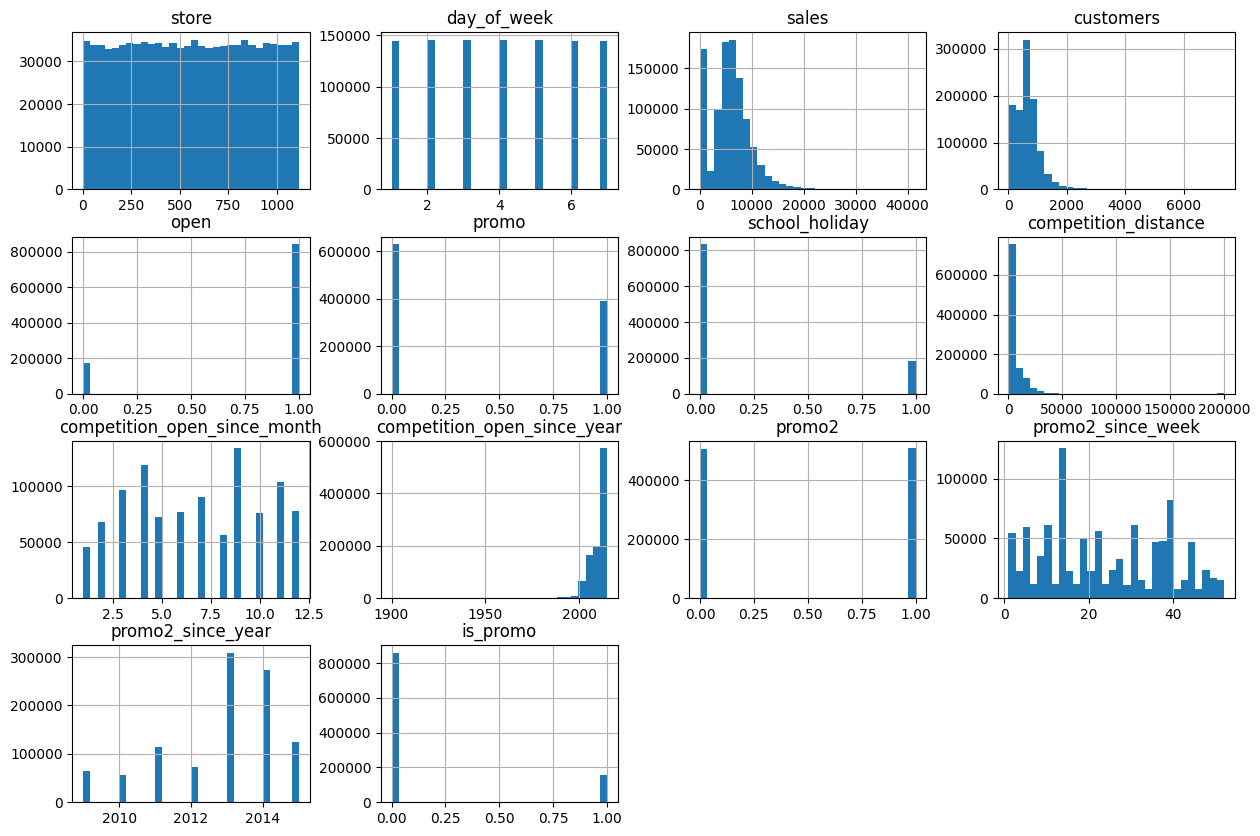

In [71]:
num_atributes.hist(bins=30, figsize=(15, 10))

### 1.7.1 Categorical attributes

In [72]:
cat_atributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

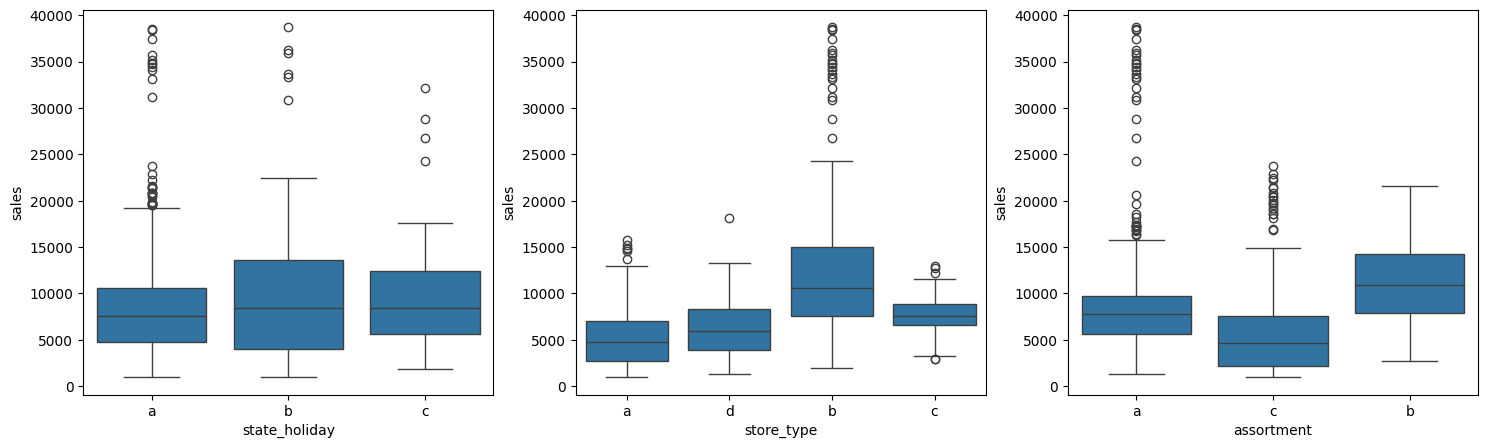

In [73]:
aux = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]


plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x = aux['state_holiday'], y = aux['sales'], data = aux)

plt.subplot(1, 3, 2)
sns.boxplot(x = aux['store_type'], y = aux['sales'], data = aux)

plt.subplot(1, 3, 3)
sns.boxplot(x = aux['assortment'], y = aux['sales'], data = aux)

#PS: outlier é 3X`s o desvio padrão

# Mapa Mental de Hipóteses
- Fenômeno:
    - Qual fenômeno estou modelando?

- Agentes:
    - Quem são os agentes que atuam sobre o fenômeno de interesse?

- Atributos dos agentes:
    - Qual a dewscrição dos agentes

- Lista de Hipóteses
    - Hipóteses para validar com os dados

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Juan Zimmermann\AppData\Local\Temp\ipykernel_16532\2290193720.py:2: SyntaxWarning: invalid escape sequence '\m'
  img = mpimg.imread("img\mindmap.png")


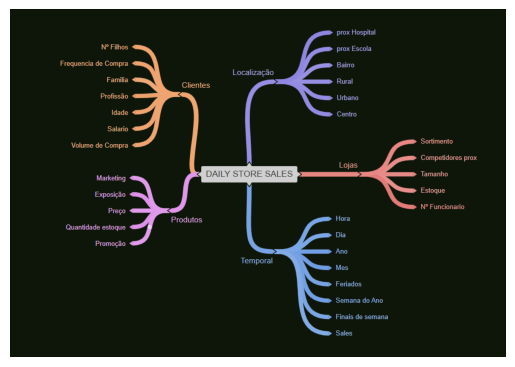

In [74]:
# Carregar imagem
img = mpimg.imread("img\mindmap.png")

# Mostrar imagem
plt.imshow(img)
plt.axis("off")  # remove os eixos
plt.show()

## Criação das hipóteses

### Hipoteses Loja
- loja com maior numero de funcionarios deveriam vender mais
- lojas com maior estoque deveriam vender mais
- lojas com maior porte deveriam vender mais
- lojas com maior sortimento deveriam vender mais
- lojas com competidores mais proximos deveriam vender menos
- lojas com competidores à mais tempo deveriam vender mais

### Hipoteses produto
- lojas que investem mais em marketing deveriam vender mais
- lojas que expoem mais os produtos na vitrine deveriam vender mais
- lojas que tem preços menores no produto everiam vender mais
- lojas que tem preços menores por mais tempo deveriam vender mais
- lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.
- lojas com promoções ativas por mais tempo deveriam vender mais
- lojas com mais promoções consecutivas deveriam vender mais


### Hipoteses tempo
- lojas abertas durante o feriado de natal deveriam vender mais
- lojas deveriam vender mais ao longo dos anos
- lojas deveriam vender mais no segundo semestre do ano
- lojas deveriam vender mais depois do dia 10 de cada mes
- lojas deveriam vender menos aos finais de semana
- lojas deveriam vender menos durante os feriados escolares

# 2.0 Feature Engineering

In [75]:
df2 = df1.copy()

In [76]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of week
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['week_of_year'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1) #criando data completa do competidor

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int) # sub p/ calcular tempo em meses

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x =='b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 Variable Selection

In [77]:
df3 = df2.copy()

In [78]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [79]:
#'open' != 0 modelo fica restrito a aprender q lojas fechadas nn vendem
#'sales' > 0 lojas sem vendas estão fechadas

df3 = df3[(df3['sales'] > 0) & (df3['open'] != 0)]

## 3.2 Seleção das Colunas

In [80]:
#baseado do contexto, não tem como prever quantos clientes teremos daqui a 6 semanas (projeto separado. prever cleintes e por como input na previsão)
df3.drop(columns=['customers', 'open', 'promo_interval', 'month_map'], axis=1, inplace=True)

# 4.0 EDA

In [81]:
df4 = df3.copy()

## 4.1 Análise univariada

### 4.1.1 Response Varibles

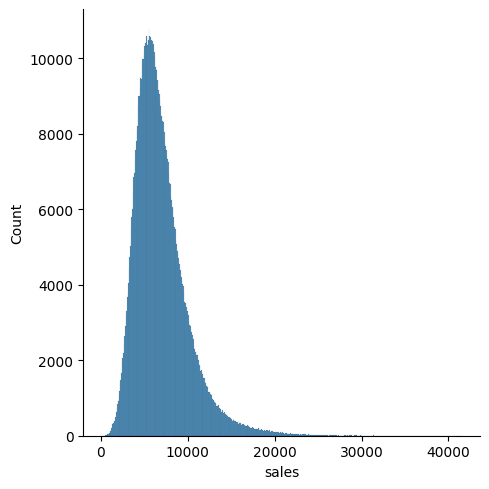

In [82]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Varibles

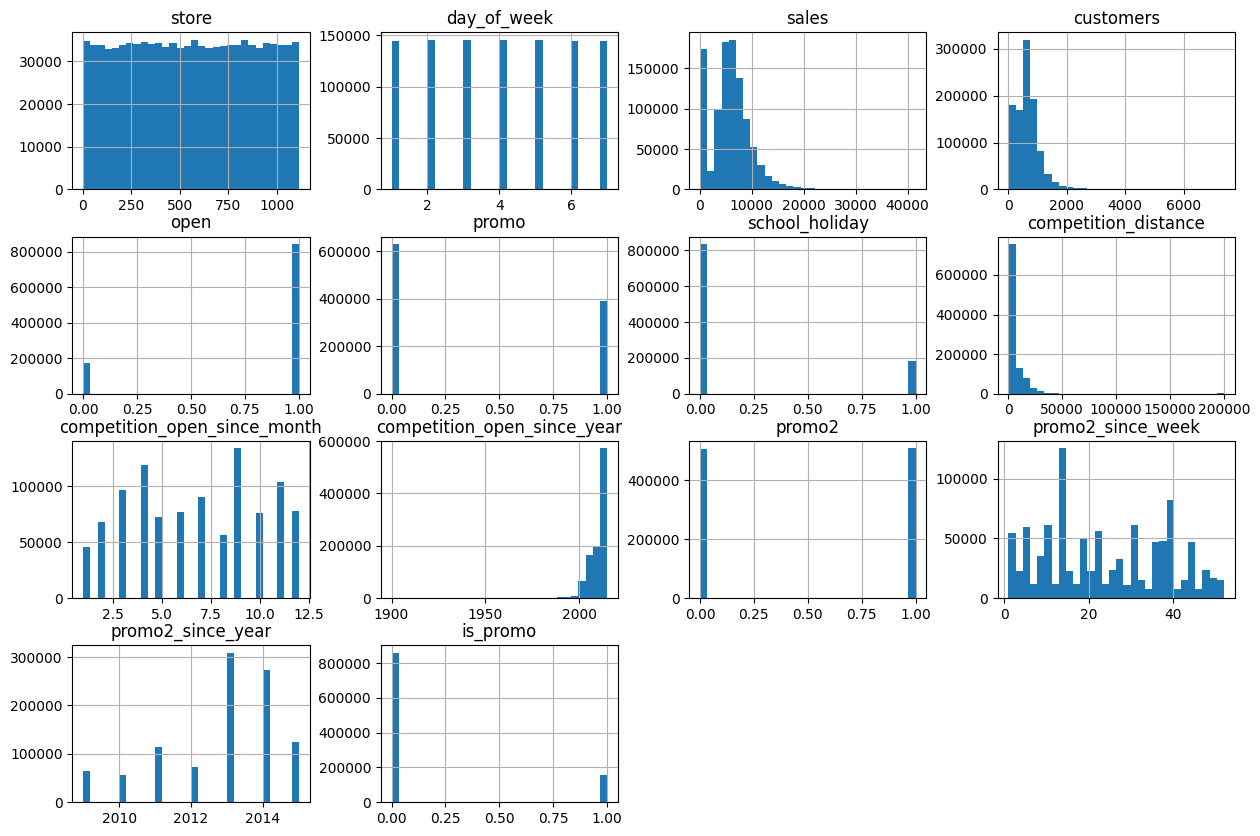

In [83]:
num_atributes.hist(bins=30, figsize=(15, 10));

### 4.1.3 Categorical Varibles

In [84]:
df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

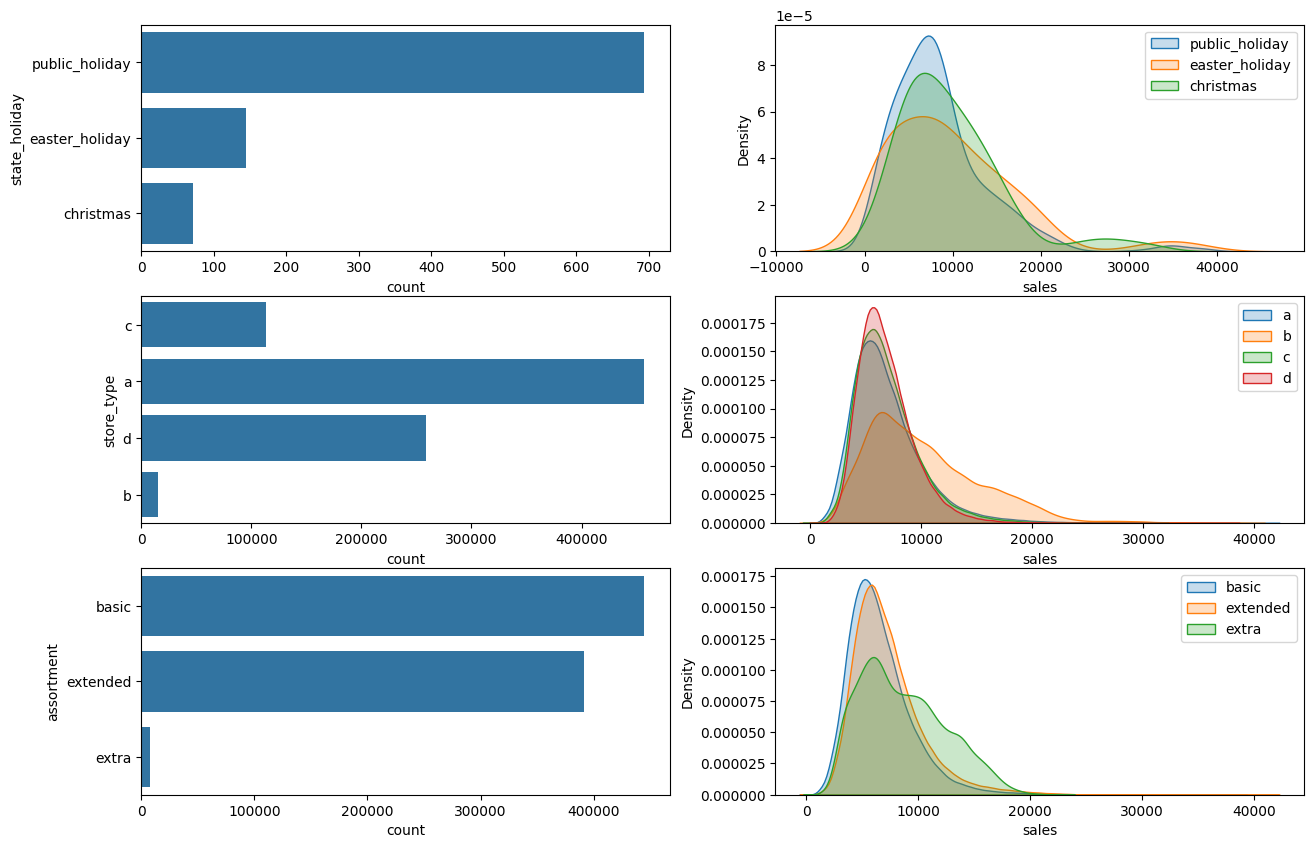

In [85]:
plt.figure(figsize=(15, 10))

#state_holiday

plt.subplot(3, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(aux['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday' ,fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday' ,fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas' ,fill=True)
plt.legend()

#store_type

plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a' ,fill=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b' ,fill=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c' ,fill=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d' ,fill=True)
plt.legend()

#assortment

plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic' ,fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended' ,fill=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra' ,fill=True)
plt.legend()

## 4.2 Análise bivariada

### H1. Lojas com maior sortimento deveriam vender mais
FALSA: lojas com maior sortimento vendem menos

<Axes: xlabel='assortment', ylabel='sales'>

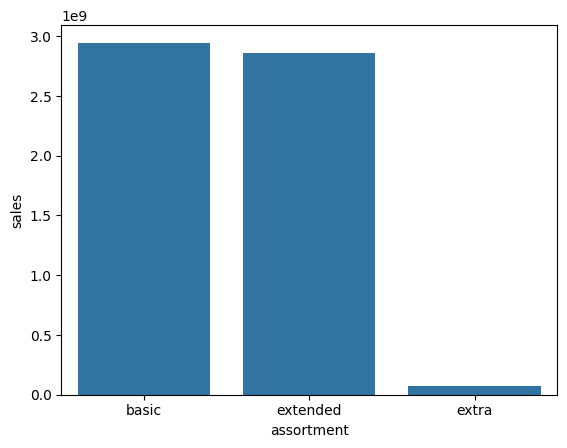

In [86]:
aux = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

sns.barplot(data = aux, x='assortment', y='sales')

Segundo o grafico, o assortment extra vende menos

#### H1.1: Será que houve alguma mudança de comportamento ao longo do tempo.

Ex: Extra vendia muito no passado, mas passou a vender menos, e no acumulado ele fica com o valor pequeno

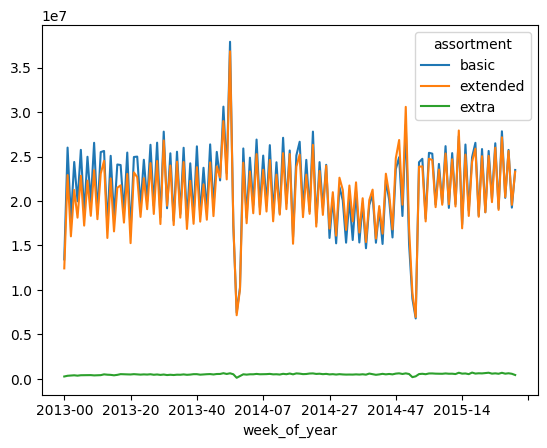

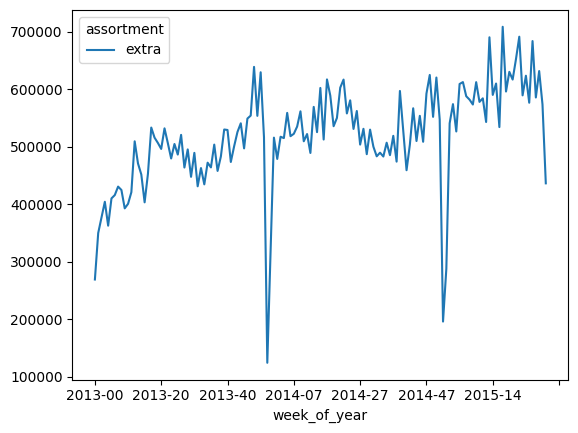

In [87]:
aux = df4[['week_of_year', 'assortment', 'sales']].groupby(['week_of_year', 'assortment']).sum().reset_index()
aux = aux.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot()

# entendendo o comportamento apenas do extra
aux1 = df4.loc[df4['assortment'] == 'extra', ['week_of_year', 'assortment', 'sales']].groupby(['week_of_year', 'assortment']).sum().reset_index()
aux1 = aux1.pivot(index = 'week_of_year', columns = 'assortment', values = 'sales').plot()

FALSA: lojas com maior sortimento vendem menos

### H2. Lojas com competidores mais proximos deveriam vender menos
Falsa: lojas com competidores mais proximos vendem mais

C:\Users\Juan Zimmermann\AppData\Local\Temp\ipykernel_16532\1178988729.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux = aux[['competition_distance_bins', 'sales']].groupby('competition_distance_bins').sum().reset_index()


<Axes: >

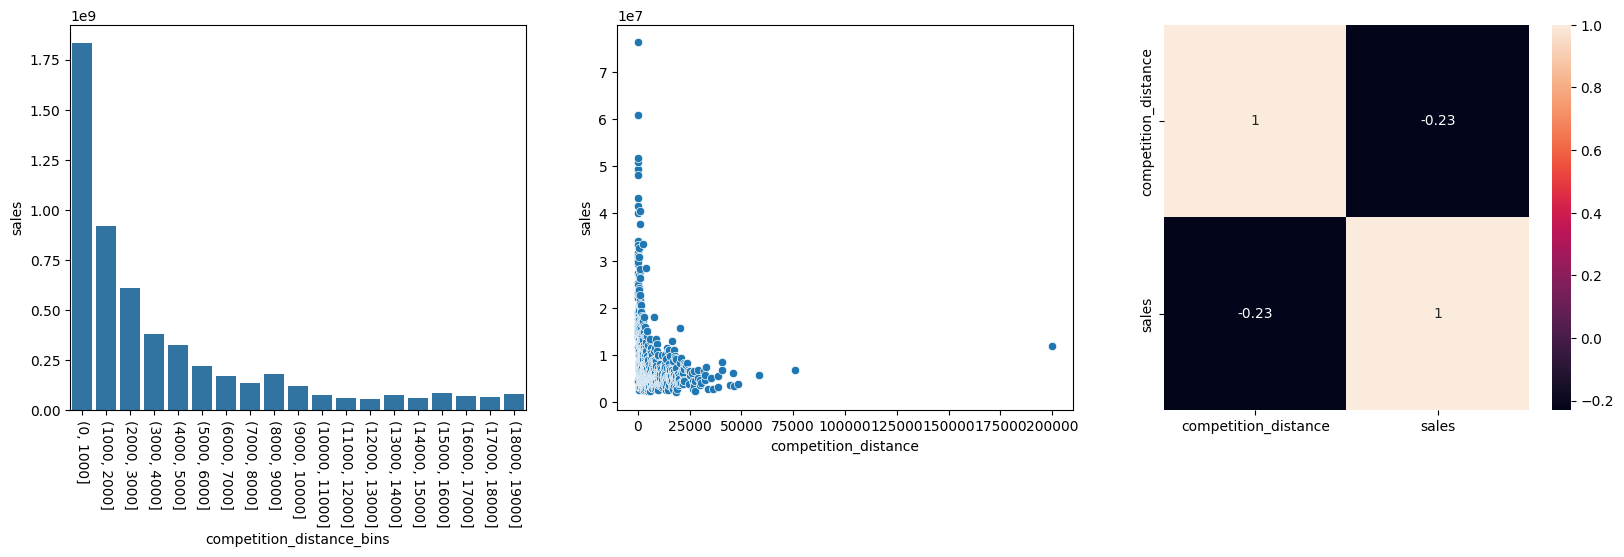

In [88]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
# definindo bins range(inicio, final, step)
bins = list(np.arange(0, 20000, 1000))
# coluna com bins
aux['competition_distance_bins'] = pd.cut(aux['competition_distance'], bins=bins)
# agrupando pelo bins
aux = aux[['competition_distance_bins', 'sales']].groupby('competition_distance_bins').sum().reset_index()
# plotando
sns.barplot(data = aux, x = 'competition_distance_bins', y = 'sales')
plt.xticks(rotation=-90)

plt.subplot(1, 3, 2)
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(data = aux, x = 'competition_distance', y = 'sales')

plt.subplot(1, 3, 3)
aux = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.heatmap(aux.corr(method='pearson'), annot=True)

Falsa: lojas com competidores mais proximos vendem mais

### H3 Lojas com competidores a mais tempo deveriam vender mais
FALSO: lojas com competidores a mais tempo vendem menos

 - valor negativo, pois é a o tempo até a abertura de um concorrente

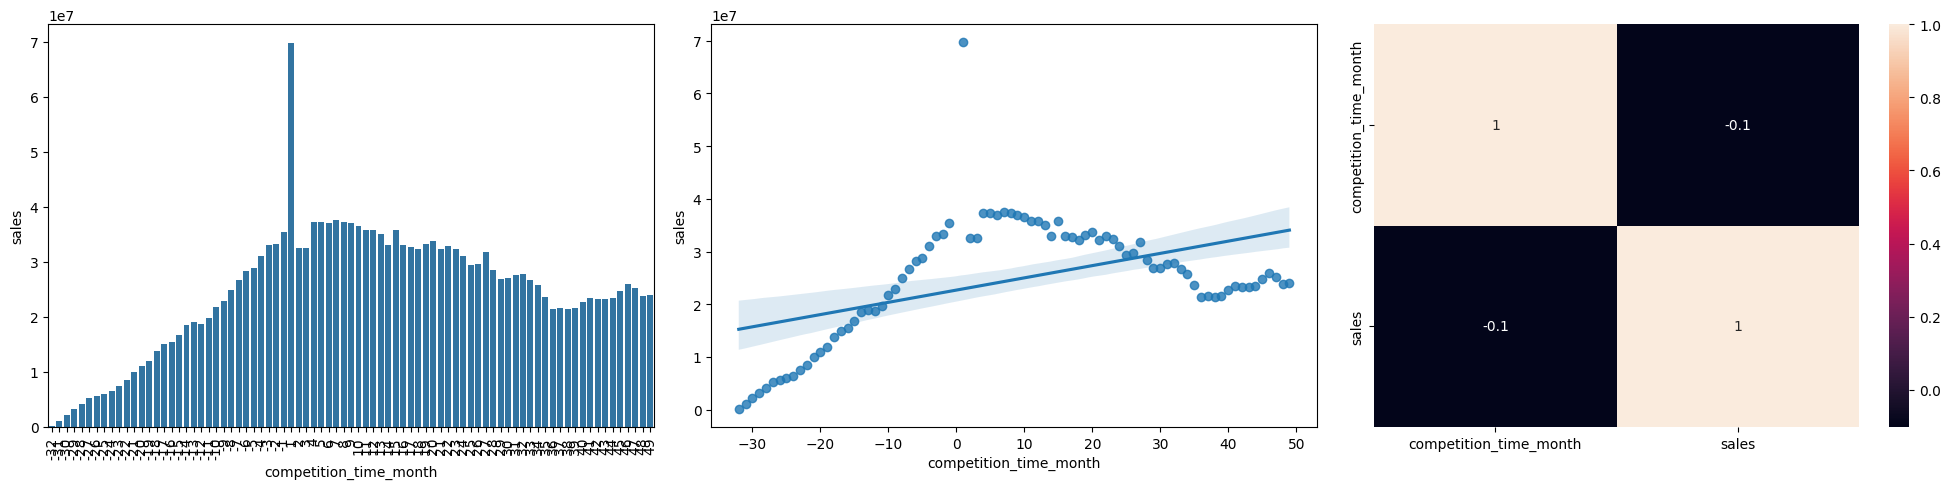

In [89]:
plt.figure(figsize=(20, 5))

aux = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux = aux[(aux['competition_time_month'] < 50) & (aux['competition_time_month'] != 0)]

plt.subplot(1, 3, 1)
sns.barplot(data = aux, x = 'competition_time_month', y = 'sales')
plt.xticks(rotation = 90)

plt.subplot(1, 3, 2)
sns.regplot(data = aux, x = 'competition_time_month', y = 'sales')

plt.subplot(1, 3, 3)
aux = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
sns.heatmap(aux.corr(method='pearson'), annot=True)

# Ajustar espaçamento
plt.tight_layout()
plt.show()

FALSO: lojas com competidores a mais tempo vendem menos

### H4 lojas com promoções ativas por mais tempo deveriam vender mais
Falso - lojas com promoções ativas por mais tempo vendem menos, depois de um periodo de promoção

(array([-140., -120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.]),
 [Text(-140.0, 0, '−140'),
  Text(-120.0, 0, '−120'),
  Text(-100.0, 0, '−100'),
  Text(-80.0, 0, '−80'),
  Text(-60.0, 0, '−60'),
  Text(-40.0, 0, '−40'),
  Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20')])

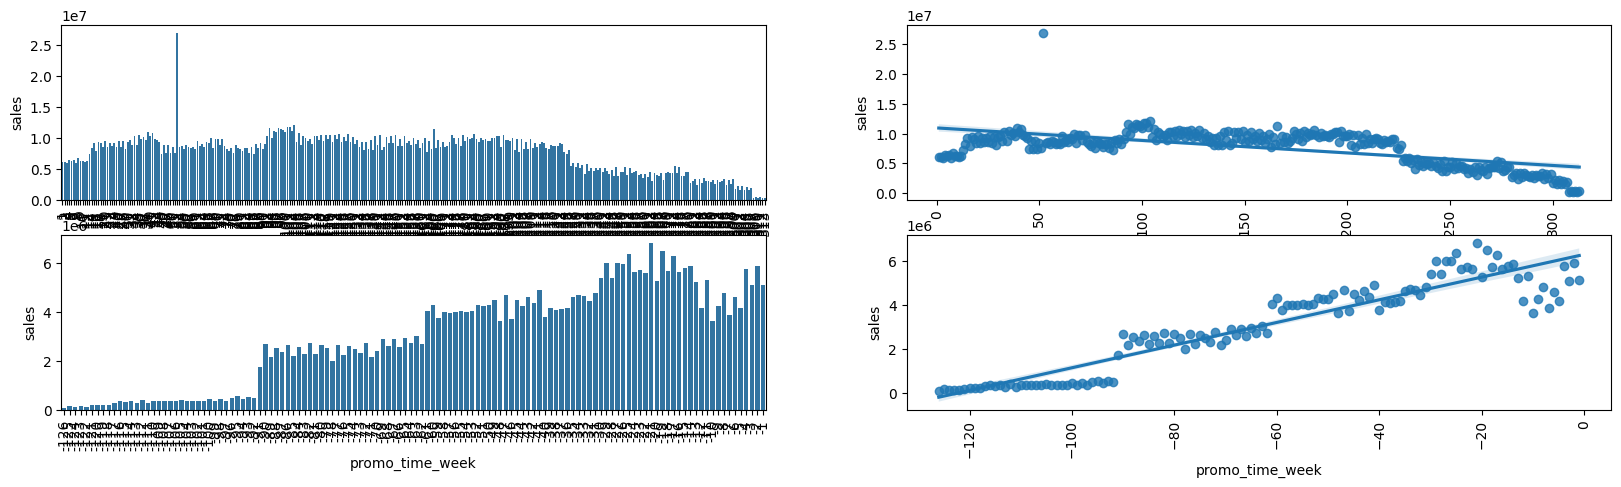

In [90]:
#positivos - venda realizada no periodo estendido de promo
# negativo - venda realizada no periodo normal

plt.figure(figsize=(20, 5))

aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# bar
plt.subplot(2, 2, 1)
aux1 = aux[aux['promo_time_week'] > 0] #periodo de promo (extentido)
sns.barplot(data=aux1, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

# reg
plt.subplot(2, 2, 2)
aux2 = aux[aux['promo_time_week'] > 0] #periodo regular
sns.regplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

# bar
plt.subplot(2, 2, 3)
aux2 = aux[aux['promo_time_week'] < 0] #periodo regular
sns.barplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

# reg
plt.subplot(2, 2, 4)
aux2 = aux[aux['promo_time_week'] < 0] #periodo regular
sns.regplot(data=aux2, x='promo_time_week', y='sales')
plt.xticks(rotation=90)

#plt.subplot(2, 2, 5)
#sns.heatmap(aux.corr(method='pearson'), annot=True)

<Axes: >

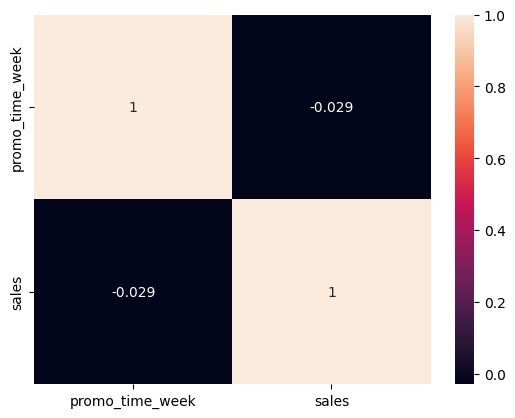

In [91]:
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

sns.heatmap(aux.corr(method='pearson'), annot=True)

Falso - lojas com promoções ativas por mais tempo vendem menos, depois de um periodo de promoção

### <s>H5 lojas com mais dias de promoção deveriam vender mais</s>

### H6 lojas com mais promoções consecutivas deveriam vender mais
Falso - lojas com mais promoções consecutivas vendem menos

In [92]:
df4[['promo', 'promo2', 'sales', ]].groupby(['promo', 'promo2']).sum().reset_index().sort_values(by='sales', ascending=False)

,promo,promo2,sales
2,1,0,1628930532
0,0,0,1482612096
3,1,1,1472275754
1,0,1,1289362241


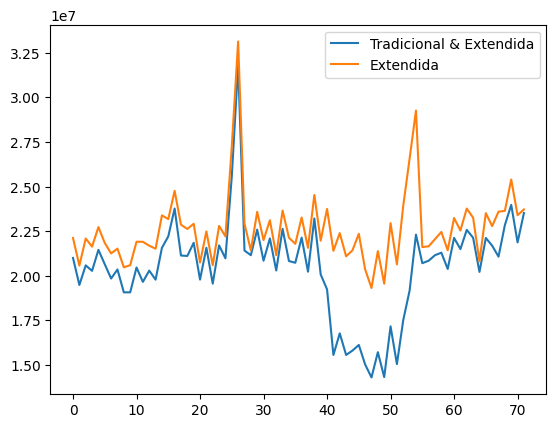

In [93]:
aux1 = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 1), ['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
ax = aux1.plot()

aux2 = df4.loc[(df4['promo'] == 1) & (df4['promo2'] == 0), ['week_of_year', 'sales']].groupby('week_of_year').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

Falso - lojas com mais promoções consecutivas vendem menos

### H7 lojas abertas durante o feriado de natal deveriam vender mais
Falso - lojas vendem menos no feriado de natal

<Axes: xlabel='year', ylabel='sales'>

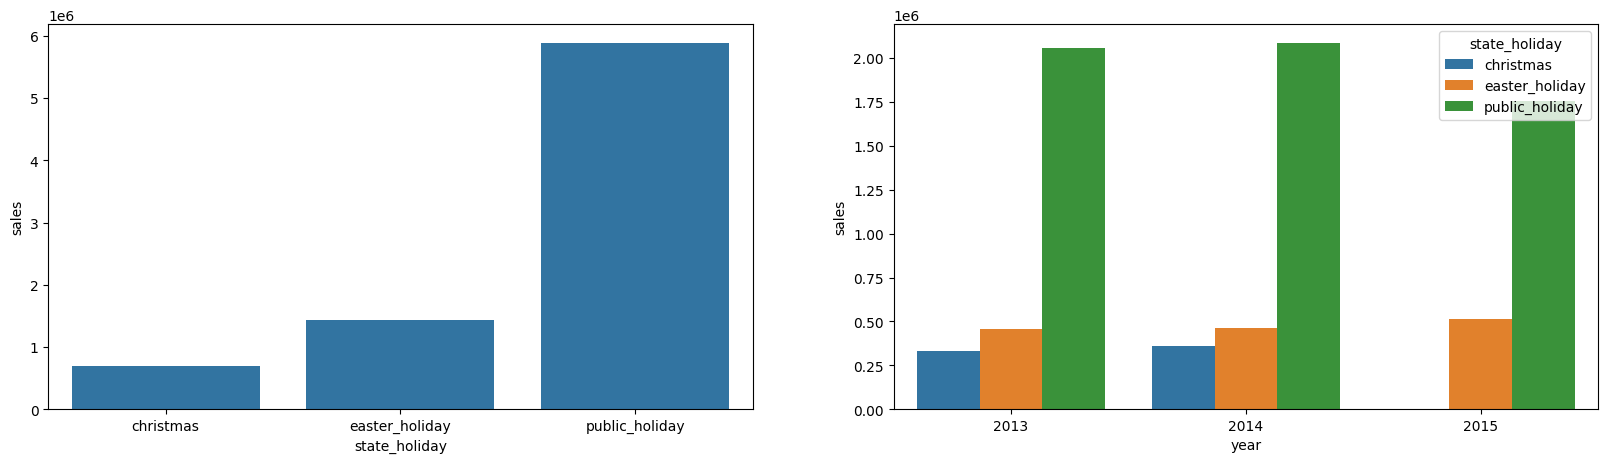

In [94]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
aux = df4.loc[df4['state_holiday'] != 'regular_day', ['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux, x='state_holiday', y='sales')

plt.subplot(1, 2, 2)
aux = df4.loc[df4['state_holiday'] != 'regular_day', ['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux, x='year', y='sales', hue='state_holiday')

### H8 lojas deveriam vender mais ao longo dos anos
Falso - lojas vendem menos ao longo dos anos

<Axes: >

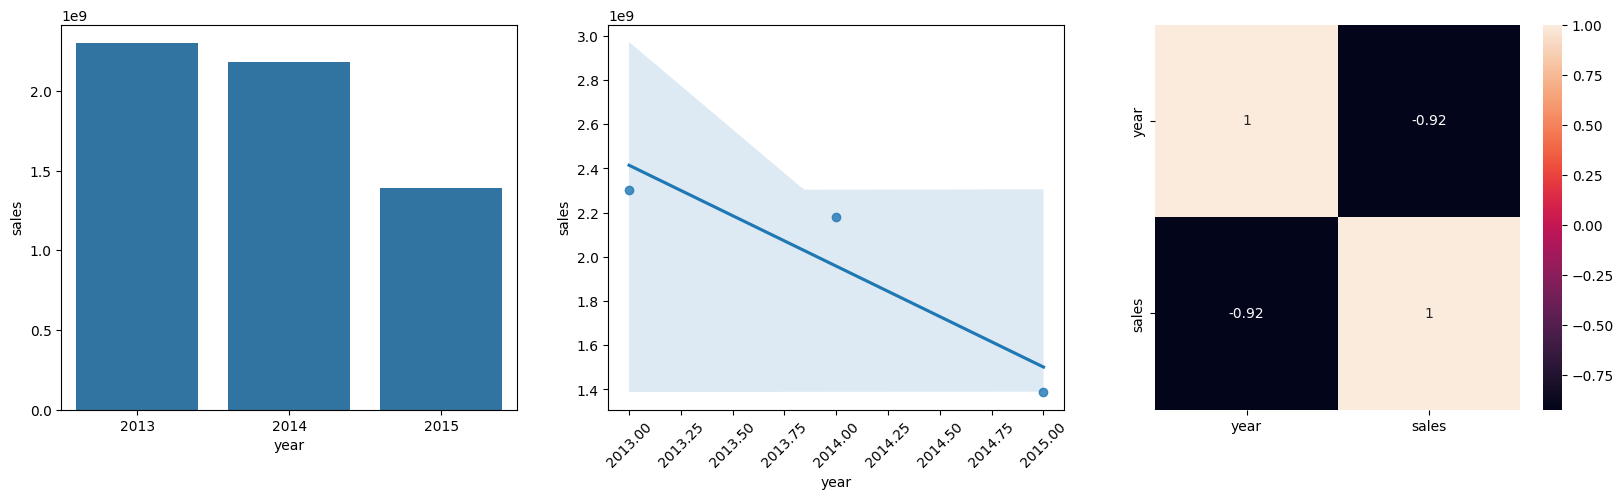

In [95]:
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=aux, x='year', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux, x='year', y='sales')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

### H9 lojas deveriam vender mais no segundo semestre do ano
Falso - lojas vendem mais no primeiro semestre do ano

<Axes: >

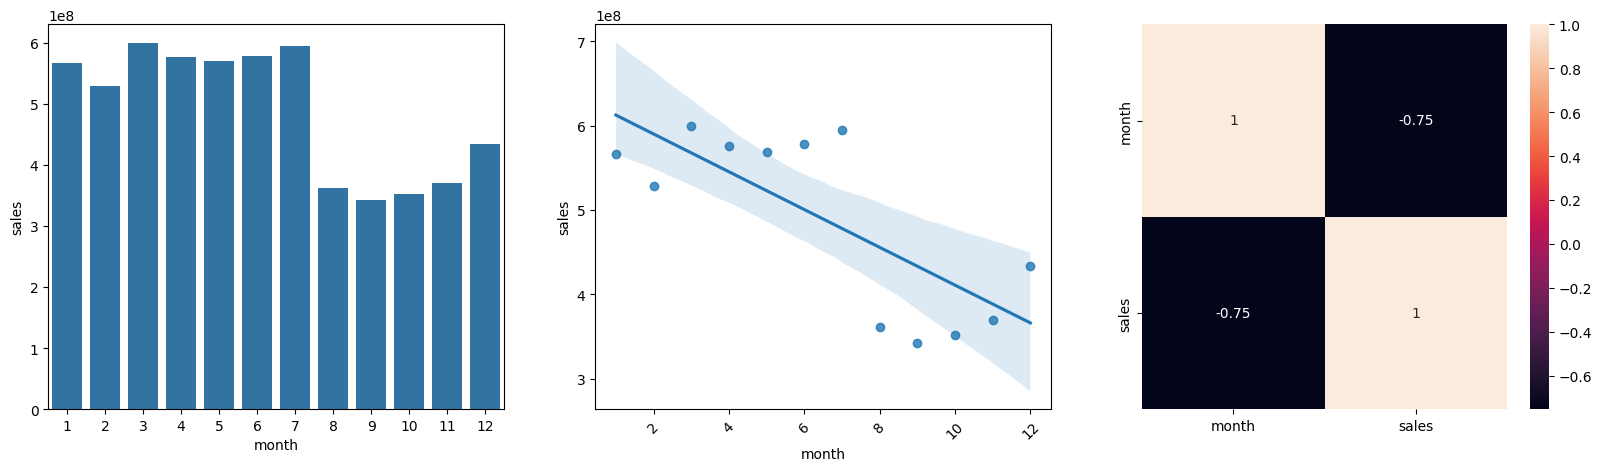

In [96]:
aux = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=aux, x='month', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux, x='month', y='sales')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

### H10 lojas deveriam vender mais depois do dia 10 de cada mes
Verdadeira - lojas vendem mais depois do dia 10 de cada mes

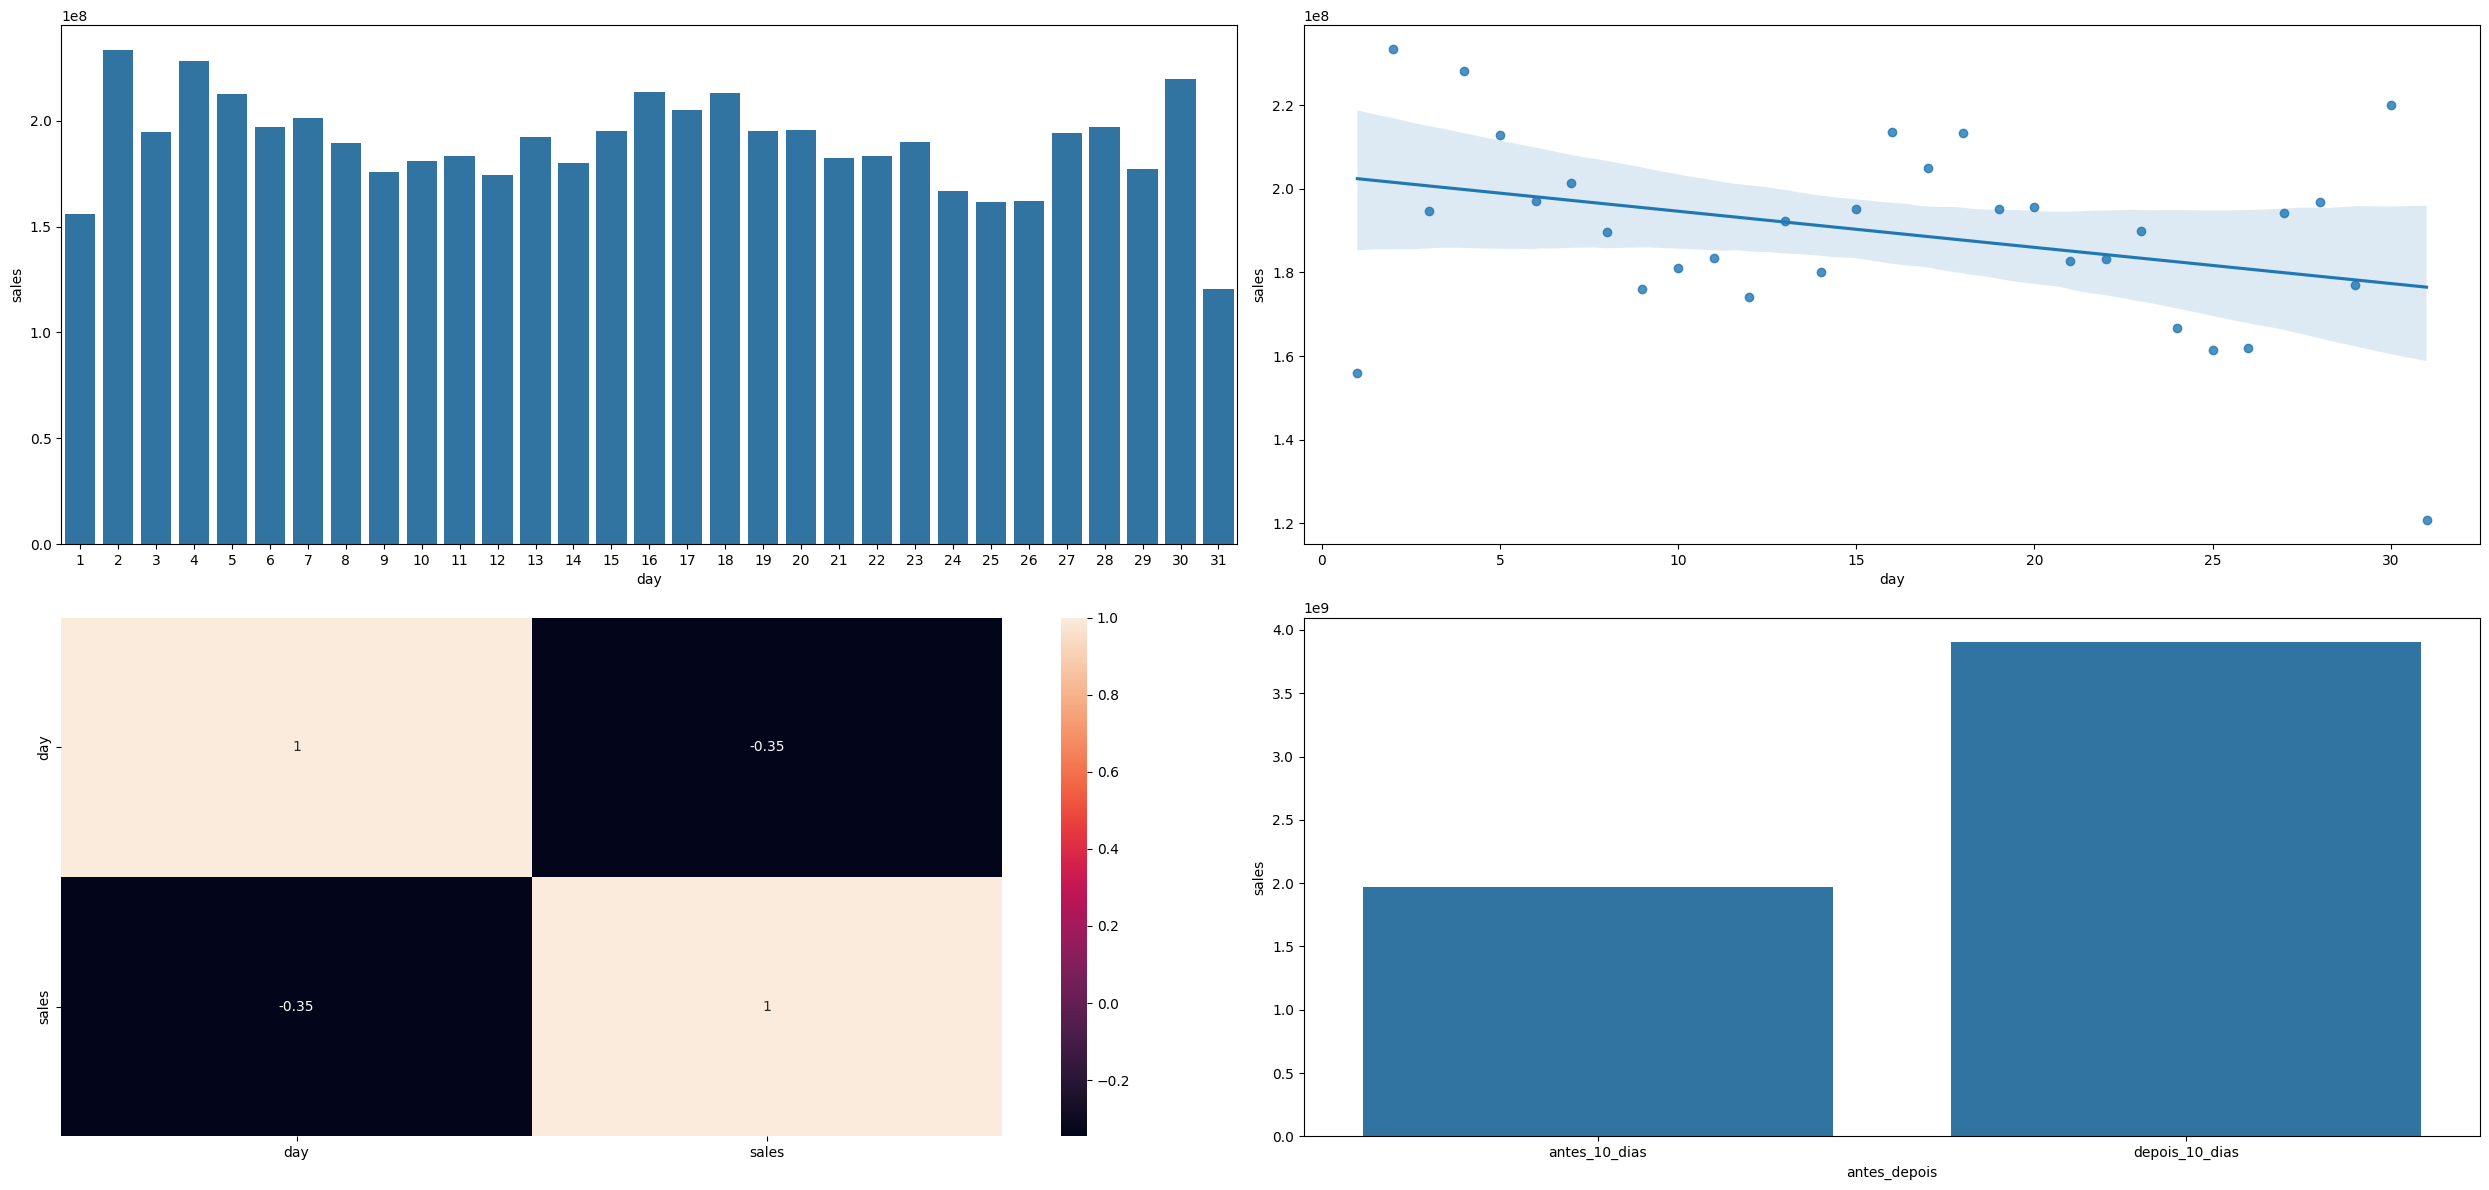

In [97]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(25, 12))

plt.subplot(2, 2, 1)
sns.barplot(data=aux1, x='day', y='sales')

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='day', y='sales')

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

# Criando antes/depois
aux1['antes_depois'] = aux1['day'].apply(lambda x: 'antes_10_dias' if x <= 10 else 'depois_10_dias')
aux2 = aux1[['antes_depois', 'sales']].groupby('antes_depois').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x='antes_depois', y='sales', data=aux2)

# Ajustar espaçamento
plt.tight_layout()
plt.show()

### H11 lojas deveriam vender menos aos finais de semana
Verdadeira - lojas vendem menos aos finais de semana

<Axes: >

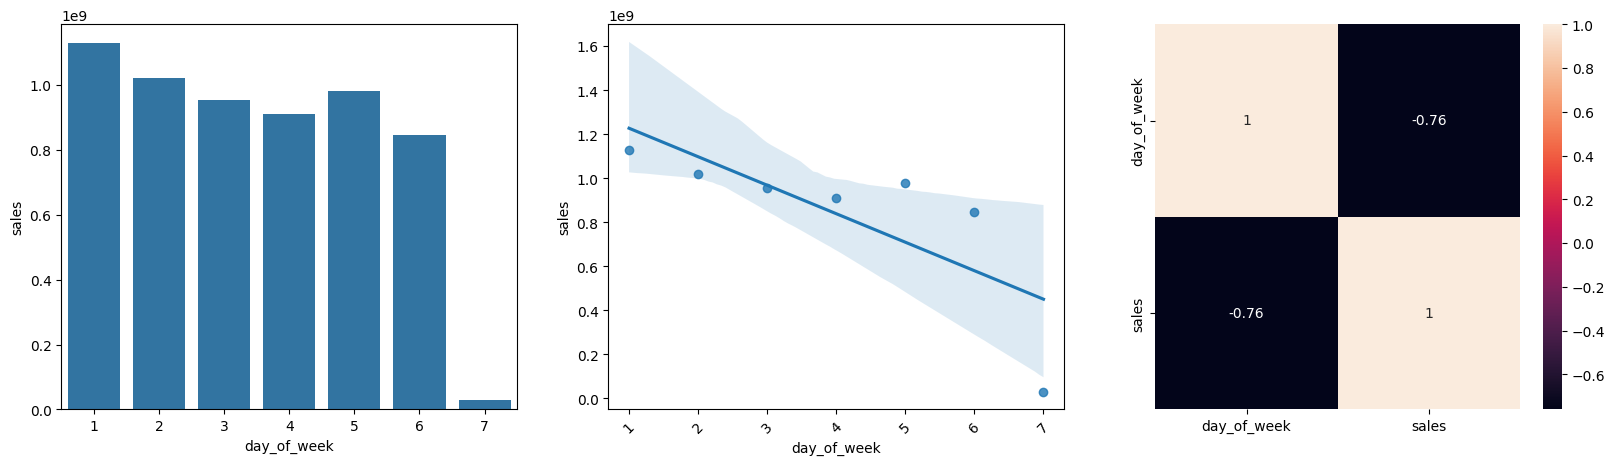

In [98]:
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=aux, x='day_of_week', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux, x='day_of_week', y='sales')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

### H12 lojas deveriam vender menos durante os feriados escolares
Verdadeira - lojas vendem menos em feriados escolares, exceto os meses de julho agosto

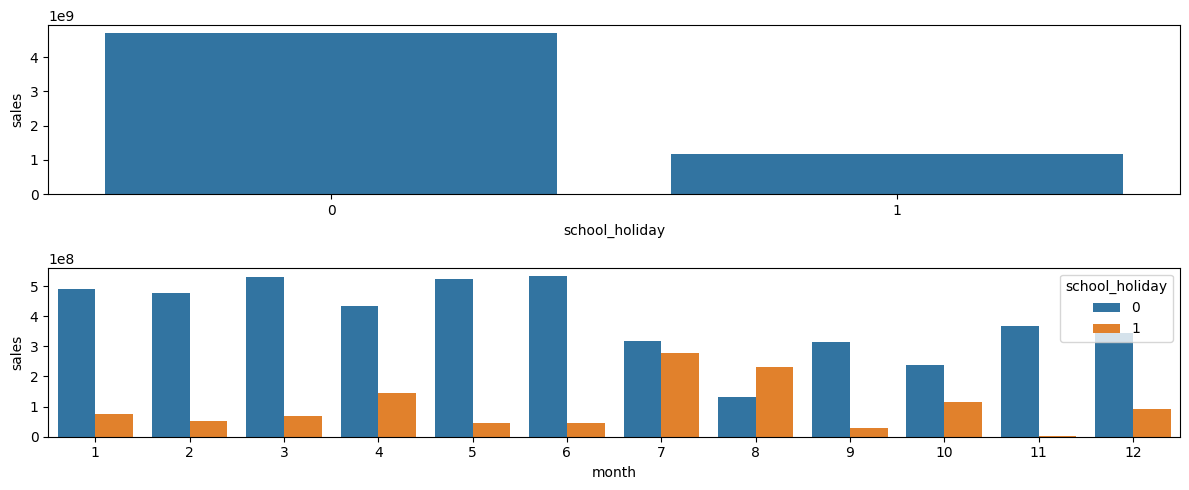

In [99]:
plt.figure(figsize=(12, 5))

aux = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(data=aux, x='school_holiday', y='sales')

plt.subplot(2, 1, 2)
aux2 = df4[['month' ,'school_holiday', 'sales']].groupby(['month' ,'school_holiday']).sum().reset_index()
sns.barplot(data=aux2, x='month', y='sales', hue='school_holiday')

# Ajustar espaçamento
plt.tight_layout()
plt.show()

### Resumo das hipoteses

In [100]:
from tabulate import tabulate
tab = [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H6', 'Falsa', 'Baixa'],
    ['H7', 'Falsa', 'Media'],
    ['H8', 'Falsa', 'Alta'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Verdadeira', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Baixa']
]

# Exibe a tabela com cabeçalhos
print(tabulate(tab[1:], headers=tab[0], tablefmt='fancy_grid'))

╒═════════════╤═════════════╤══════════════╕
│ Hipoteses   │ Conclusao   │ Relevancia   │
╞═════════════╪═════════════╪══════════════╡
│ H1          │ Falsa       │ Baixa        │
├─────────────┼─────────────┼──────────────┤
│ H2          │ Falsa       │ Media        │
├─────────────┼─────────────┼──────────────┤
│ H3          │ Falsa       │ Media        │
├─────────────┼─────────────┼──────────────┤
│ H4          │ Falsa       │ Baixa        │
├─────────────┼─────────────┼──────────────┤
│ H5          │ -           │ -            │
├─────────────┼─────────────┼──────────────┤
│ H6          │ Falsa       │ Baixa        │
├─────────────┼─────────────┼──────────────┤
│ H7          │ Falsa       │ Media        │
├─────────────┼─────────────┼──────────────┤
│ H8          │ Falsa       │ Alta         │
├─────────────┼─────────────┼──────────────┤
│ H9          │ Falsa       │ Alta         │
├─────────────┼─────────────┼──────────────┤
│ H10         │ Verdadeira  │ Alta         │
├─────────

## 4.3 Análise multivariada

### 4.3.1 Numerical attributes

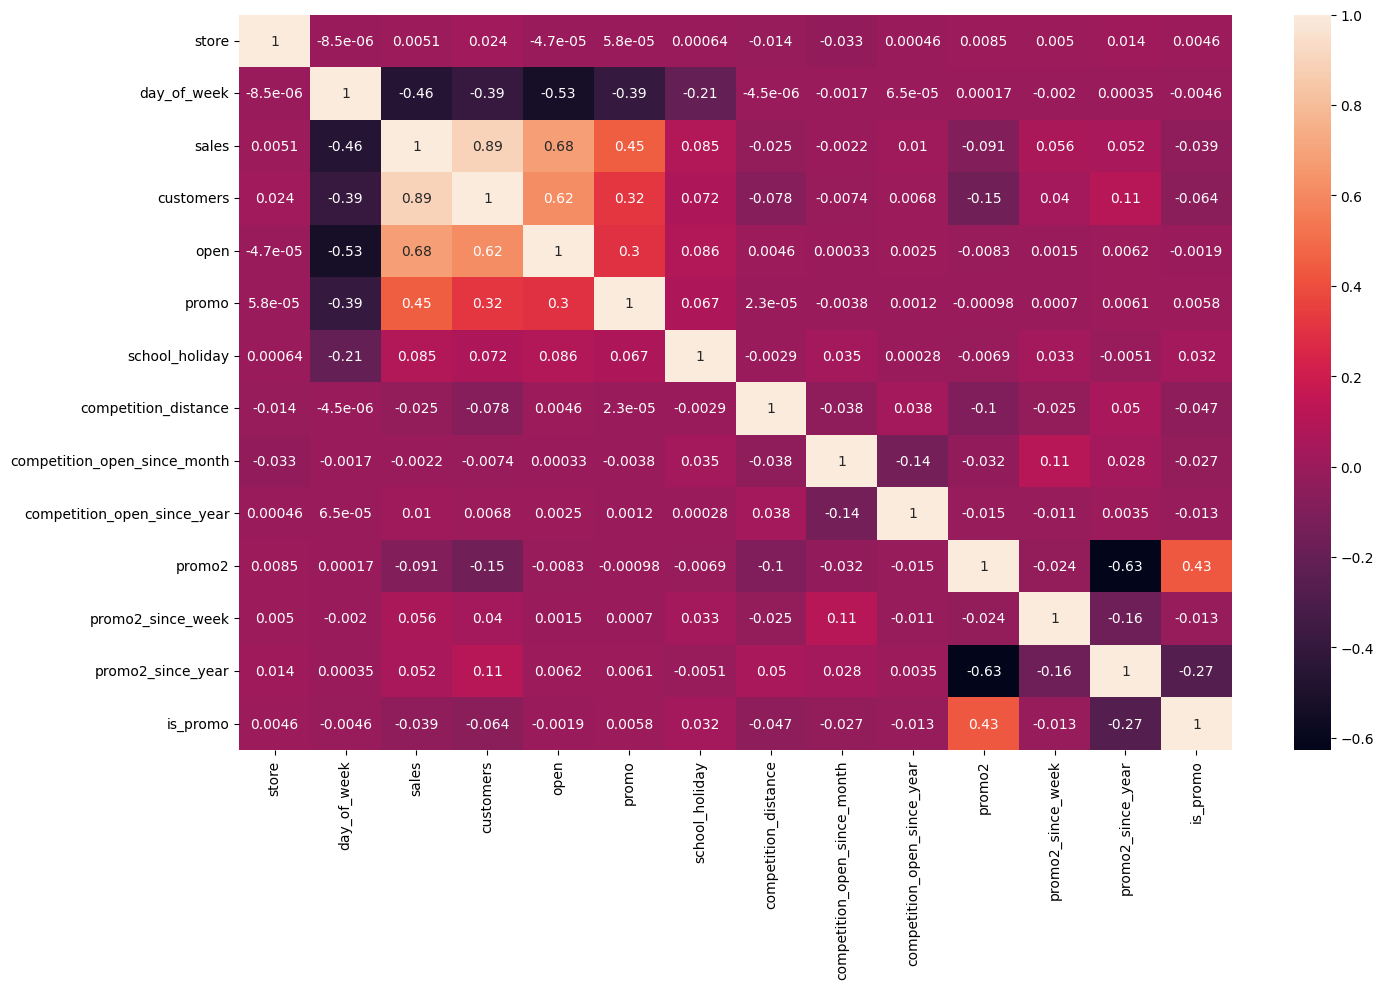

In [101]:
plt.figure(figsize=(15, 10))

correlation = num_atributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

# Ajustar espaçamento
plt.tight_layout()
plt.show()

### 4.3.2 categorical attributes

O Cramér's V é uma medida estatística baseada no teste do qui-quadrado (χ²). Ele retorna um valor entre 0 e 1, onde:

- 0 → Nenhuma associação entre as variáveis.

- 1 → Associação perfeita entre as variáveis.

<Axes: >

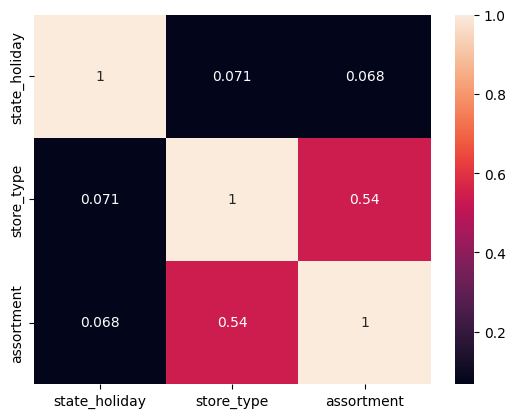

In [102]:
# apenas categoricos
a = df4.select_dtypes(include='object')

# calculando cramer v
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# dataset final
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 Preparação dos dados
"O aprendizado da maioria dos algoritmos de ML é facilitado com dados numéricos, na mesma escala"

Normalização
- Rescala o centro para 0 com desvio padrao = 1

Rescaling
- Rescala para o intervalo entre 0 e 1
- Distribuição nãoo Gaussianas

Transformação
- Conversão de features categóricas para numericas (Encoding)
- Transformação de natureza

In [103]:
df5 = df4.copy()

In [104]:
num_atributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


## 5.1 Normalização
(var - media) / desvio padrão

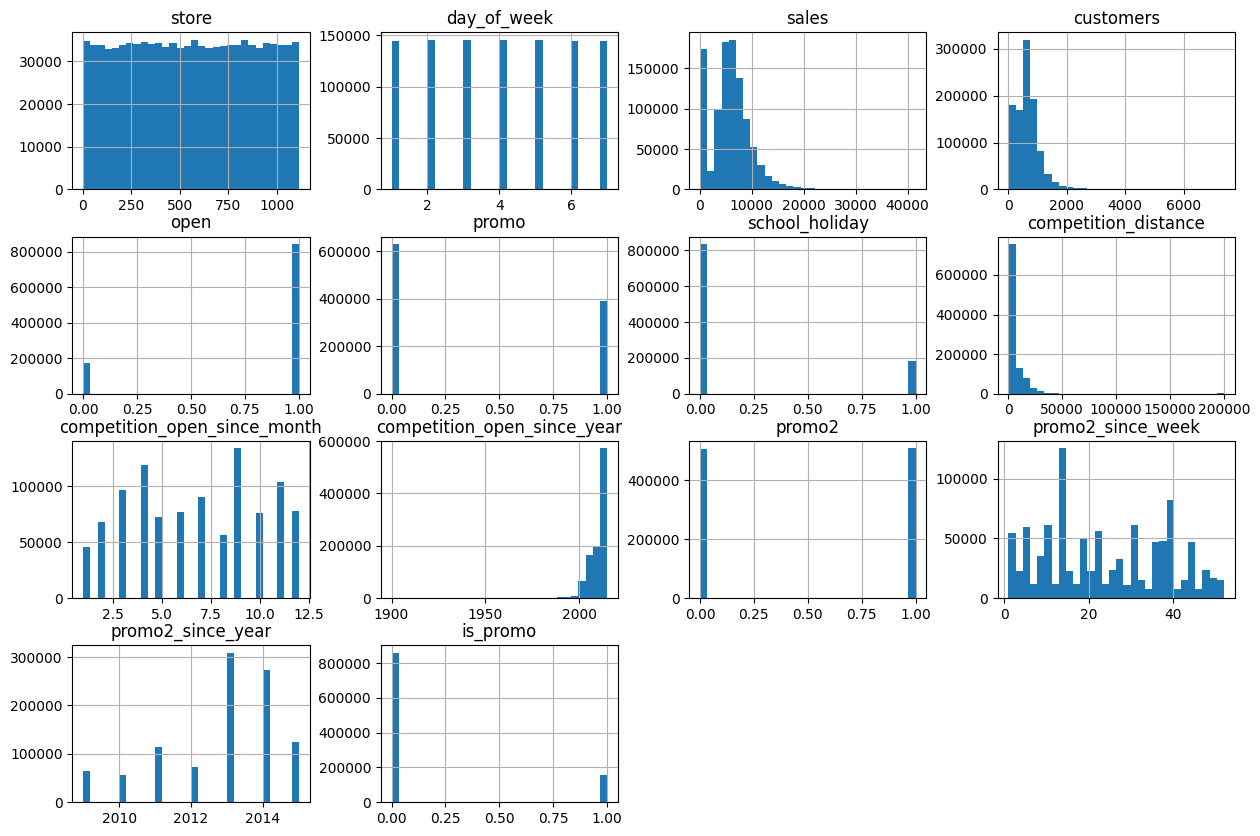

In [105]:
num_atributes.hist(bins=30, figsize=(15, 10));

Sem variáveis com distribuição normal

## 5.2 Rescaling

### Min-Max Scaler
Xnew = media da coluna / valor max - valor minimo

Boa para usar em variaveis sem outliers

*atenção: sensivel para outliers*

In [106]:
mms = MinMaxScaler()

#promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

#year
df5['year'] = mms.fit_transform( df5[['year']].values )

### Robust Scaler
Xnew = media da coluna / 1° quartil - 3° quartil

Alternativa para outliers presentes

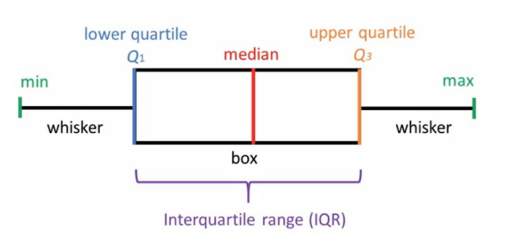

In [107]:
# Carregar imagem
img = mpimg.imread("img/boxplot.png")

# Mostrar imagem
plt.imshow(img)
plt.axis("off")  # remove os eixos
plt.show()

In [108]:
rs = RobustScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

#competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

### Visualizando *Rescaling*

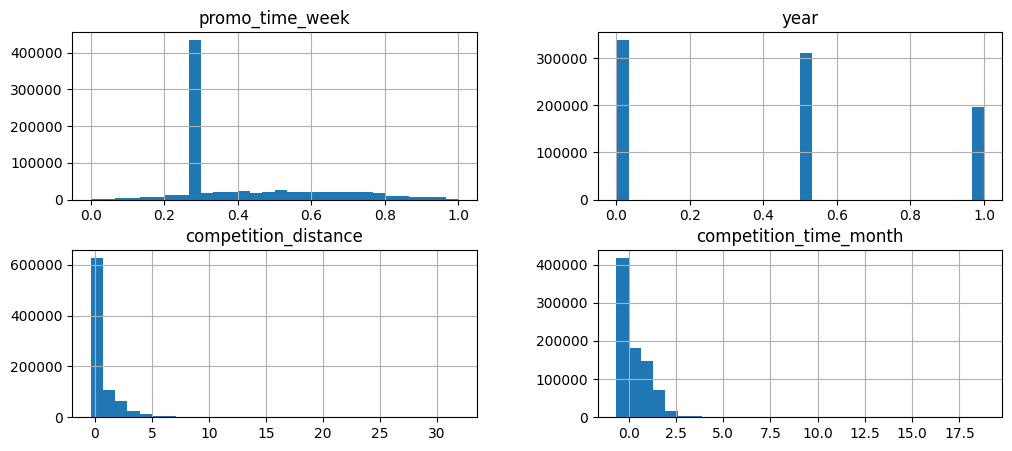

In [109]:
reescala = df5.loc[:, ['promo_time_week', 'year', 'competition_distance', 'competition_time_month']]

reescala.hist(bins=30, figsize=(12, 5));

## 5.2 Encoding

### 5.2.1 One Hot Encoding

- criaçao de colunas com valores unicos na col origem (1 - sim / 0 - não)

In [ ]:
#state_holiday
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

### 5.2.2 Label Encoding

- troca de nomes das var por numeros
    - nomes de loja, cor, nome de pessoas

In [ ]:
#store_type
le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])

### 5.2.3 Ordinal Encoding
- troca de nomes das var por numeros
    - temperatura (frio - 1, morno - 2, quente - 3, muito quente - 4)

In [118]:
#assortment
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.2.4 Target Encoding
- funciona quando tem var categoricas com muitos niveis

### 5.2.5 Frequency Encoding
- parecido com target, mas ele trás a 'contagem' respectiva da categoria

### 5.2.6 Embedding Encoding
- camadas q fazem a traduçao da var cat para numerica mentendo relação de distancia dentro de um contexto
    - palavras que podem ser mais proximas umas das outras dependendo do contexto
    - utilizado em NLP

## 5.3 Transformação

In [ ]:
#month

#day

#week_of_year

#day_of_week

# 6.0

# 7.0

# 8.0